# Predict the type of star

#### Name of the students:  
  Sebastian Lazarte C.  
  Diego Delgadillo C.  

We are given datasets to train an artificial neural network so that we can get the prediction of what type of star is based on the information of the dataset (temperature, luminosity, magnitude, etc.).  
In order to get a model capable of predict the type we have to handle the dataset and make some changes that are explained on this report, such as give values to categorycal data, normalize the data, etc.  
For this we will use the python library *pandas, tensorflow, numpy, sklearn and keras*. Those are the libraries that we are importing on the next cell.

In [1244]:
import pandas as pd
import tensorflow as tf
import numpy as np
import math
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder
from keras import models
from keras import layers
from keras import regularizers
import matplotlib.pyplot as plt
from keras import optimizers
from numpy.random import seed
from numpy import array
from numpy import argmax
from keras import metrics
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from tensorflow.keras import optimizers

Then we must have the datasets on the same directory as this notebook.  
Once we have them there we can read them as below.

In [1245]:
file_path_assignment = os.path.join("data", "assignment_ds.csv")
file_path_test = os.path.join("data", "test_ds.csv")
file_path_sample = os.path.join("data", "sample_submission.csv")


First we put a seed so that we can have a consistent result (it doesn't change on every iteration).
Then we read the csv file.

In [1246]:
seed(10)
dataf_assigment = pd.read_csv(file_path_assignment)
dataf_assigment.head()

,Temperature,L,R,A_M,Color,Spectral_Class,Type
0,3453,0.000621,0.0773,17.08,Red,M,0
1,12098,689.000000,7.0100,0.02,Blue-white,A,3
2,2731,0.000437,0.0856,18.09,Red,M,0
3,37800,202900.000000,6.8600,-4.56,Blue,O,3
4,8570,0.000810,0.0097,14.20,Blue white,A,2


# Dataframe cleaning

The first thing we do is check if there are any null values on the data.


In [1247]:
null_columns=dataf_assigment.columns[dataf_assigment.isnull().any()] #Returns if there is any null value on the columns
dataf_assigment[null_columns].isnull().sum()  # We can see how many null values are in the columns
print(dataf_assigment[dataf_assigment.isnull().any(axis=1)][null_columns].head()) # Prints the position of the null value. As we can see, there is no null value in the dataframe

Empty DataFrame
Columns: []
Index: []


# Colors cleaning



Then we check the columns with categorical values, in this case we have 'Color' and 'Spectral_Class'.


With this command we can see the values that appear at least once in the selected column. In this case are the values that are present on the column 'Color'.

In [1248]:
dataf_assigment['Color'].unique()

array(['Red', 'Blue-white', 'Blue', 'Blue white', 'Whitish', 'White',
       'Blue White', 'yellowish', 'white', 'yellow-white',
       'Yellowish White', 'Orange', 'White-Yellow', 'Pale yellow orange',
       'Orange-Red', 'Blue-White', 'Yellowish'], dtype=object)

As we can see, there are colors that are the same but with different name, so they don't match as the same color.

The next thing to do is to change the values of the colors so that they could tbe generic. In this case we look for pure colors, not a mix.

In [1249]:

dataf_assigment['Color'] = dataf_assigment['Color'].map({'Blue-white':'Blue', 'Blue white':'Blue', 'Blue-White':'Blue', 'Blue White':'Blue', 'Blue':'Blue',
                             'Whitish':'White', 'white':'White','White':'White',
                             'yellowish':'Yellow', 'yellow-white':'Yellow', 'Yellowish White':'Yellow', 'White-Yellow':'Yellow', 'Yellowish':'Yellow','Yellow':'Yellow',
                             'Pale yellow orange':'Orange','Orange':'Orange',
                             'Orange-Red':'Red','Red':'Red'})

In [1250]:
dataf_assigment['Color'].unique()

array(['Red', 'Blue', 'White', 'Yellow', 'Orange'], dtype=object)

Once the process is done, we get only generic colors in the column and we can classify them with numbers.

Another categorial column we have is the 'Spectral Class' as said before.

In [1251]:
dataf_assigment['Spectral_Class'].unique()

array(['M', 'A', 'O', 'B', 'K', 'F', 'G'], dtype=object)

Now we can assign a number to the categorical values. This will help us to make all the information a number so that we can process it.

In [1252]:
# Now we have to give the colors a value
dataf_assigment['Color'] = dataf_assigment['Color'].map({'Blue':1,
                             'White':2,
                             'Yellow':3,
                             'Orange':4,
                             'Red':5})
#Also we have to give a value to the spectral_class
dataf_assigment['Spectral_Class'] = dataf_assigment['Spectral_Class'].map({'M':1,
                             'B':2,
                             'O':3,
                             'K':4,
                             'F':5,
                             'A':6,
                             'G':7})
dataf_assigment.head()

,Temperature,L,R,A_M,Color,Spectral_Class,Type
0,3453,0.000621,0.0773,17.08,5,1,0
1,12098,689.000000,7.0100,0.02,1,6,3
2,2731,0.000437,0.0856,18.09,5,1,0
3,37800,202900.000000,6.8600,-4.56,1,3,3
4,8570,0.000810,0.0097,14.20,1,6,2


# Split Inputs/Target from Dataset

In [1253]:
# shuffle dataset
dataf_assigment = dataf_assigment.sample(frac=1)

# get inputs - outputs
inputs = dataf_assigment[['Temperature','L','R','A_M','Color','Spectral_Class']]
target = dataf_assigment[['Type']]

# Normalize data

In [1254]:
# scale input data
x = inputs.values #returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
inputs = pd.DataFrame(x_scaled)
inputs[0:10]

,0,1,2,3,4,5
0,0.042984,1.448047e-01,0.023090,0.160725,1.0,0.000000
1,0.043772,1.483365e-01,0.576852,0.034709,1.0,0.000000
2,0.703108,1.976643e-02,0.003280,0.244841,0.0,0.166667
3,0.973726,2.401639e-01,0.005436,0.225766,0.0,0.333333
4,0.028980,4.944550e-10,0.000075,0.891807,1.0,0.000000
5,0.017919,6.121824e-10,0.000046,0.773296,1.0,0.000000
6,0.040750,3.178640e-01,0.780086,0.078799,1.0,0.000000
7,0.039227,6.945916e-10,0.000093,0.902439,1.0,0.000000
8,0.017367,3.767276e-10,0.000045,0.916823,1.0,0.000000
9,0.020809,4.202868e-10,0.000040,0.938399,1.0,0.000000


# Hot enconde outputs

First we get to see the style of our output column.

In [1255]:
target.head()

,Type
59,4
5,5
20,3
198,3
52,0


Then we proceed to hot encode it.

In [1256]:
#integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(target)

# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
target = pd.DataFrame(onehot_encoded)

target.head()

D:\.Programas\anaconda\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


,0,1,2,3,4,5
0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0


# Split Training Set from Validation Set

In [1257]:
# define training dataset size
ds_size = inputs.shape[0]
train_size_percentage = .7
test_size_percentage = .2

training_size = int(ds_size * train_size_percentage)
test_size = int(ds_size * test_size_percentage)

# get training data
input_training = inputs[:training_size]
target_training = target[:training_size]

# get test data
input_test = inputs[training_size:(training_size + test_size)]
target_test = target[training_size:(training_size + test_size)]

# get validation data
input_validation = inputs[(training_size + test_size):]
target_validation = target[(training_size + test_size):]

# used during training
print('Training DS size:', input_training.shape[0])
print('Test DS size:', input_test.shape[0])

# used during validation
print('Validation DS size', input_validation.shape[0])

Training DS size: 140
Test DS size: 40
Validation DS size 20


In [1258]:
print('inputs:')
print(inputs[:10])
print('target')
target[:10]

inputs:
          0             1         2         3    4         5
0  0.042984  1.448047e-01  0.023090  0.160725  1.0  0.000000
1  0.043772  1.483365e-01  0.576852  0.034709  1.0  0.000000
2  0.703108  1.976643e-02  0.003280  0.244841  0.0  0.166667
3  0.973726  2.401639e-01  0.005436  0.225766  0.0  0.333333
4  0.028980  4.944550e-10  0.000075  0.891807  1.0  0.000000
5  0.017919  6.121824e-10  0.000046  0.773296  1.0  0.000000
6  0.040750  3.178640e-01  0.780086  0.078799  1.0  0.000000
7  0.039227  6.945916e-10  0.000093  0.902439  1.0  0.000000
8  0.017367  3.767276e-10  0.000045  0.916823  1.0  0.000000
9  0.020809  4.202868e-10  0.000040  0.938399  1.0  0.000000
target


,0,1,2,3,4,5
0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0
5,0.0,1.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,1.0
7,1.0,0.0,0.0,0.0,0.0,0.0
8,1.0,0.0,0.0,0.0,0.0,0.0
9,1.0,0.0,0.0,0.0,0.0,0.0


# Train Neural Network 

Define Neural Network Architecture.

*   For this part there is an input shape of 6 because there are 6 columns with values that are the inputs.
*   In this Architecture there a 3 hidden layers the first one with 32 neourons, a second with 8 neourons and a third one with 8 neourons all using sigmoid function as activation function.
*   And there are 6 different outputs that represent the values that a star type represents. (0.Red Dwarf 1.Brown Dwarf 2.White Dwarf 3.Main Sequence 4.Super Giants 5.Hyper Giants ).e
*   Also we had to make some experiments with the learning rate. At the beggining it was a value of 0.1 and we had an average of 0.80 on the categorical accuracy. It was good but trying with a learning rate of 0.01 we saw a big improvement on the model. The average has grown up to 0.95 and we got a lot of 1 in the categorical accuracy value.

In [1308]:
# neural network
model = models.Sequential()

# input layer
model.add(layers.Dense(64, activation='relu', input_shape=(6,)))

# hidden layers
model.add(layers.Dense(16, activation='sigmoid'))
model.add(layers.Dense(16, activation='sigmoid'))

# output layers
model.add(layers.Dense(6, activation='sigmoid'))
    
rmsprop = optimizers.RMSprop(learning_rate=0.01)
#learning_rate changed from 0.1 to 0.01
model.compile(optimizer=rmsprop, loss='mse', metrics=[metrics.categorical_accuracy])

In this part we had to do some experiments first to decide the number of epochs. At the beggining there were 180 but the result was not pretty accurate so we increase the number and we determine that 250 was a good number of epochs.

In [1309]:
num_epochs = 250
batch_size = 64

history = model.fit(input_training, target_training,
                            validation_data=(input_test, target_test),
                            epochs=num_epochs, batch_size=batch_size, verbose=1)

Epoch 1/250
3/3 [==============================] - 0s 47ms/step - loss: 0.2408 - categorical_accuracy: 0.1786 - val_loss: 0.1693 - val_categorical_accuracy: 0.1750
Epoch 2/250
3/3 [==============================] - 0s 9ms/step - loss: 0.1606 - categorical_accuracy: 0.1786 - val_loss: 0.1503 - val_categorical_accuracy: 0.1750
Epoch 3/250
3/3 [==============================] - 0s 8ms/step - loss: 0.1447 - categorical_accuracy: 0.1786 - val_loss: 0.1458 - val_categorical_accuracy: 0.1750
Epoch 4/250
3/3 [==============================] - 0s 9ms/step - loss: 0.1405 - categorical_accuracy: 0.1786 - val_loss: 0.1436 - val_categorical_accuracy: 0.1750
Epoch 5/250
3/3 [==============================] - 0s 9ms/step - loss: 0.1384 - categorical_accuracy: 0.1786 - val_loss: 0.1387 - val_categorical_accuracy: 0.1750
Epoch 6/250
3/3 [==============================] - 0s 9ms/step - loss: 0.1366 - categorical_accuracy: 0.2357 - val_loss: 0.1390 - val_categorical_accuracy: 0.3000
Epoch 7/250
3/3 [====

In [1310]:
epochs = range(1, num_epochs+1)

# during training
loss = history.history['loss']
accuracy = history.history['categorical_accuracy']

# outside training
val_loss = history.history['val_loss']
val_accuracy = history.history['val_categorical_accuracy']

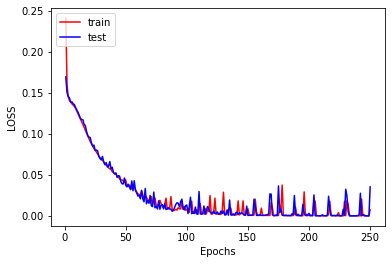

In [1311]:
# plot loss
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.xlabel('Epochs')
plt.ylabel('LOSS')
plt.legend(['train', 'test'], loc='upper left')

plt.show()
#AUMENTAR NUM EPOCHS

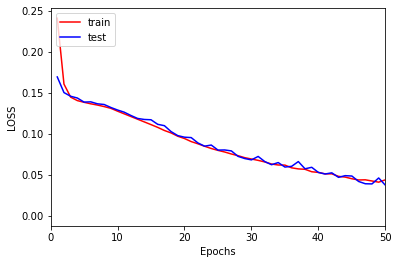

In [1315]:
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.xlabel('Epochs')
plt.ylabel('LOSS')
plt.legend(['train', 'test'], loc='upper left')
plt.xlim(0, 50)
plt.show()

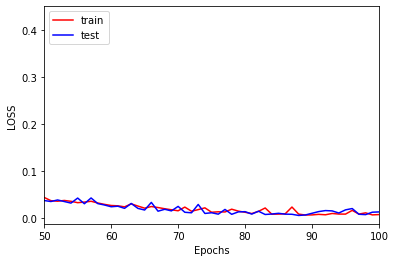

In [1312]:
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.xlabel('Epochs')
plt.ylabel('LOSS')
plt.legend(['train', 'test'], loc='upper left')
plt.xlim(50, 100)
plt.ylim(None, 0.45)
plt.show()

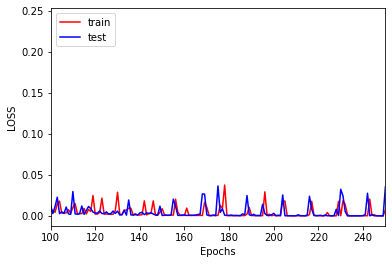

In [1316]:
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.xlabel('Epochs')
plt.ylabel('LOSS')
plt.legend(['train', 'test'], loc='upper left')
plt.xlim(100, 250)

plt.show()

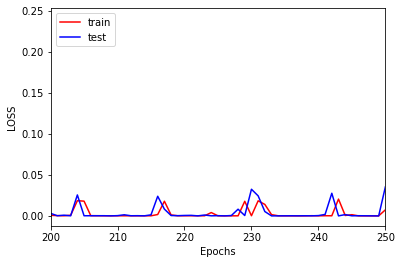

In [1314]:
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.xlabel('Epochs')
plt.ylabel('LOSS')
plt.legend(['train', 'test'], loc='upper left')
plt.xlim(200, 250)

plt.show()

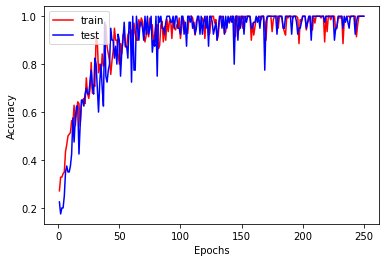

In [1276]:
# plot accuracy
plt.plot(epochs, accuracy, 'r')
plt.plot(epochs, val_accuracy, 'b')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Validate

First we get the predictions from the model using the inputs.

In [1186]:
#predict
predictions_targets = model.predict(input_validation)
predicted = label_encoder.inverse_transform(predictions_targets.argmax(1))

Then we transform the targets as they were hot encoded, and we return the values to the initial form.

In [ ]:
# target
targets_val = label_encoder.inverse_transform(np.array(target_validation.values).argmax(1))

The last thing to do is to compare, we have the target values which are the ones included on the dataset. And next to them are the predicted values and we get to see how many values were predicted correctly.

In [1158]:
# compare them
df = pd.DataFrame({'target':targets_val, 'predicted': predicted})
df

,target,predicted
0,5,5
1,1,1
2,0,1
3,3,3
4,1,1
5,5,5
6,5,5
7,4,4
8,0,1
9,4,4


# Applying to the test

Now is time for us to make some predictions based on the previously trained model. For this we will use the test_ds dataset. The first step is to convert the categorical values into number values, just like before, so that the info can be processed.

In [1160]:
dataf_test = pd.read_csv(file_path_test)
dataf_test['Color'] = dataf_test['Color'].map({'Blue-white':'Blue', 'Blue white':'Blue', 'Blue-White':'Blue', 'Blue White':'Blue', 'Blue':'Blue',
                             'Whitish':'White', 'white':'White','White':'White',
                             'yellowish':'Yellow', 'yellow-white':'Yellow', 'Yellowish White':'Yellow', 'White-Yellow':'Yellow', 'Yellowish':'Yellow','Yellow':'Yellow',
                             'Pale yellow orange':'Orange','Orange':'Orange',
                             'Orange-Red':'Red','Red':'Red'})
dataf_test['Color'] = dataf_test['Color'].map({'Blue':1,
                             'White':2,
                             'Yellow':3,
                             'Orange':4,
                             'Red':5})
#Also we have to give a value to the spectral_class
dataf_test['Spectral_Class'] = dataf_test['Spectral_Class'].map({'M':1,
                             'B':2,
                             'O':3,
                             'K':4,
                             'F':5,
                             'A':6,
                             'G':7})
dataf_test.head()

,Temperature,L,R,A_M,Color,Spectral_Class
0,21020,0.00150,0.0112,11.52,1,2
1,2935,0.00087,0.0932,16.88,5,1
2,16390,1278.00000,5.6800,-3.32,1,2
3,3628,0.00550,0.3930,10.48,5,1
4,3496,0.00125,0.3360,14.94,5,1


Then we do a similar treatment as above, we get the inputs which are the columns of the dataset. Then we have to normalize the data. And the last step is to make a prediction based on the input. After that we get the result.

In [1161]:
# get inputs
inputs = dataf_test[['Temperature','L','R','A_M','Color','Spectral_Class']]

# scale input data
x = inputs.values #returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
inputs = pd.DataFrame(x_scaled)
inputs[0:10]

predicted_classes = model.predict(inputs)
predicted_classes = np.argmax(np.round(predicted_classes), axis = 1)
predicted_classes

array([2, 0, 3, 1, 0, 1, 3, 5, 5, 2, 4, 2, 3, 0, 0, 4, 2, 5, 0, 4, 0, 5,
       4, 4, 0, 1, 0, 5, 3, 4, 3, 3, 0, 5, 0, 1, 4, 0, 0], dtype=int64)